# Import Important Library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

__1. Global Configuration__

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4

IMAGE_DIR = "./datasets/segmentation_data/images"
MASK_DIR  = "./datasets/segmentation_data/masks"

__2. Data Loading & Preprocessing__

In [13]:
def load_data(image_dir, mask_dir):
    images, masks = [], []

    files = sorted(os.listdir(image_dir))

    for f in files:
        img_path = os.path.join(image_dir, f)
        mask_path = os.path.join(mask_dir, f)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)

        images.append(img)
        masks.append(mask)

    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    masks  = np.array(masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

    return images, masks


__3. Dice Loss & Dice Coefficient__

In [15]:
# Dice coefficient
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        K.sum(y_true) + K.sum(y_pred) + smooth
    )

# Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

__4. Normal U-Net Architecture__

In [16]:
def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    return Model(inputs, outputs)


__5. Load Data & Train–Validation Split__

In [17]:
X, y = load_data(IMAGE_DIR, MASK_DIR)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 160
Validation samples: 40


__6. Compile Model__

In [18]:
model = unet_model()

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=dice_bce_loss,
    metrics=['accuracy', dice_coef]
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_15[0][0]']              
                                )                                                           

__7. Callbacks (Overfitting Protection)__

In [20]:
callbacks = [
    EarlyStopping(
        monitor='val_dice_coef',
        patience=8,
        restore_best_weights=True
    )
]

__8. Train the Model__

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
20/20 [==============================] - 9s 414ms/step - loss: 1.3581 - accuracy: 0.9846 - dice_coef: 8.0341e-04 - val_loss: 1.0844 - val_accuracy: 0.9983 - val_dice_coef: 2.0106e-10
Epoch 2/50
20/20 [==============================] - 8s 400ms/step - loss: 1.0263 - accuracy: 0.9986 - dice_coef: 3.3326e-04 - val_loss: 1.0111 - val_accuracy: 0.9983 - val_dice_coef: 0.0027
Epoch 3/50
20/20 [==============================] - 8s 401ms/step - loss: 1.0049 - accuracy: 0.9986 - dice_coef: 0.0074 - val_loss: 1.0004 - val_accuracy: 0.9983 - val_dice_coef: 0.0154
Epoch 4/50
20/20 [==============================] - 8s 403ms/step - loss: 1.0041 - accuracy: 0.9986 - dice_coef: 0.0093 - val_loss: 0.9989 - val_accuracy: 0.9983 - val_dice_coef: 0.0197
Epoch 5/50
20/20 [==============================] - 8s 403ms/step - loss: 1.0007 - accuracy: 0.9986 - dice_coef: 0.0136 - val_loss: 0.9937 - val_accuracy: 0.9983 - val_dice_coef: 0.0183
Epoch 6/50
20/20 [==============================] - 8s 408

__9. Training Curves__

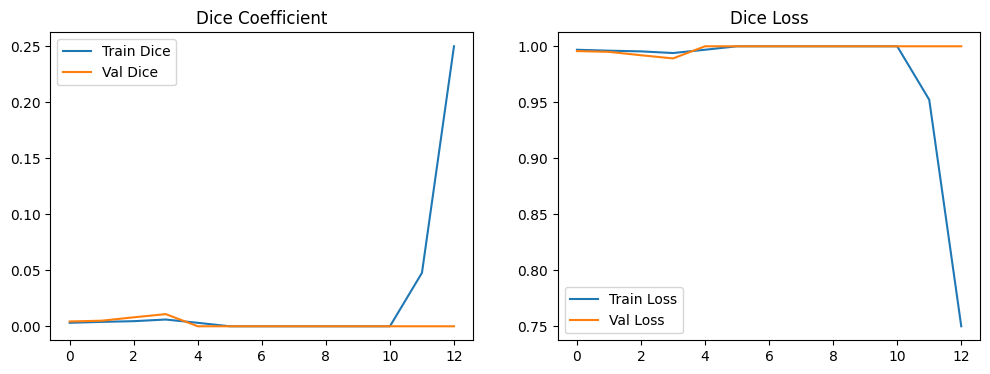

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Dice Loss')

plt.show()